<div class='bar_title'></div>

*Smart Cities and Geospatial Data Analysis*

# Assignment 7: Clustering and Regionalization

Gunther Gust / Ignacio Ubeda<br>
Chair for Enterprise AI

Winter Semester 23/24

*Credits: Most of the material is taken from [Arribas-Bel, Geographic Data Science](https://darribas.org/gds_course/content/home.html#)*

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt

from pysal.lib import weights
from pysal.lib import examples

from sklearn import cluster
from sklearn.preprocessing import MinMaxScaler

## Task I: Clustering

We are going to try to get at the (geographic) essence of New York City. For that, we will rely on the same set up Census tracts for New York City we used in a previous assignment. 

In [2]:
nyc_data = examples.load_example("NYC Socio-Demographics")
nyc = gpd.read_file(nyc_data.get_path("NYC_Tract_ACS2008_12.shp"))

print(type(nyc))
print(nyc.shape)
nyc.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(2166, 114)


,UNEMP_RATE,cartodb_id,withssi,withsocial,withpubass,struggling,profession,popunemplo,poptot,popover18,...,geo_geoid,shape_leng,shape_area,ct2010,boroct2010,borocode,tractid,popdty,geo_fips,geometry
0,0.000000,1,0,0,0,0,0,0,0,0,...,08000US360614491951000000100,11023.047911,1.844421e+06,100.0,1000100.0,1.0,1.00,0.00,3.606140e+20,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
1,0.081705,2,228,353,47,694,0,92,2773,2351,...,08000US360614491951000000201,4748.703641,9.716282e+05,201.0,1000201.0,1.0,2.01,79619.05,3.606140e+20,"POLYGON ((-73.98450 40.70951, -73.98655 40.709..."
2,0.170603,3,658,1577,198,2589,36,549,8339,6878,...,08000US360614491951000000202,8568.208357,3.315121e+06,202.0,1000202.0,1.0,2.02,72326.46,3.606140e+20,"MULTIPOLYGON (((-73.98237 40.70554, -73.98246 ..."
3,0.000000,4,0,0,0,0,0,0,0,0,...,08000US360614491951000000500,32407.899284,9.081808e+06,500.0,1000500.0,1.0,5.00,0.00,3.606140e+20,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
4,0.088037,5,736,1382,194,2953,19,379,10760,8867,...,08000US360614491951000000600,6973.204078,2.583270e+06,600.0,1000600.0,1.0,6.00,109785.00,3.606140e+20,"POLYGON ((-73.99022 40.71440, -73.98934 40.714..."


Once you have the `nyc` object loaded, create a geodemographic clustering using the following variables:

- `european`: Total Population White
- `asian`: Total Population Asian American
- `american`: Total Population American Indian
- `african`: Total Population African American
- `hispanic`: Total Population Hispanic
- `mixed`: Total Population Mixed race
- `pacific`: Total Population Pacific Islander

### NYC normalized geodemographics

- First define a DataFrame called `nyc_geodemo` to select the above variables from `nyc`.
- Normalize the table by the size of each tract. That is, compute a column with the total population as the sum of all the ethnic groups and divide each of them by that column. This way, the values will range between 0 (no population of a given ethnic group) and 1 (all the population in the tract is of that group).

**Hint 1:** If the **total population** column is 0, then impute the values for each etnic group with 0

**Hint 2:** After the normalization step, don't forget to drop the column with the total!

In [3]:
#select the geodemographics variables
nyc_geodemo = nyc[['european', 'asian', 'american', 'african', 'hispanic', 'mixed', 'pacific']]

#create total column (row-wise sum) 
nyc_geodemo['total'] = nyc_geodemo.sum(axis=1)

#divide each column by total
for column_name in nyc_geodemo.columns:
    nyc_geodemo[column_name] = nyc_geodemo[column_name]/nyc_geodemo['total']

#impute nan (case total=0) with 0
nyc_geodemo[pd.isna(nyc_geodemo)] = 0

#drop the total column
nyc_geodemo = nyc_geodemo.drop('total', axis=1)

nyc_geodemo.head()

/var/folders/td/mhppvrk10nj_1j1gl_dk2pvc0000gn/T/ipykernel_6512/866406510.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_geodemo['total'] = nyc_geodemo.sum(axis=1)
/var/folders/td/mhppvrk10nj_1j1gl_dk2pvc0000gn/T/ipykernel_6512/866406510.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_geodemo[column_name] = nyc_geodemo[column_name]/nyc_geodemo['total']
/var/folders/td/mhppvrk10nj_1j1gl_dk2pvc0000gn/T/ipykernel_6512/866406510.py:12: SettingWithCopyWarning: 
A value is trying to be set on a c

,european,asian,american,african,hispanic,mixed,pacific
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.160619,0.371505,0.012790,0.049970,0.353064,0.052052,0.000000
2,0.383519,0.161620,0.000000,0.104528,0.328396,0.021937,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.102083,0.566082,0.004927,0.078658,0.225430,0.021696,0.001124


### K-means clustering

Once the normalization is ready, get to work with the clustering:

1. Pick a number of clusters (e.g. 5)
1. Run K-Means for that number of clusters

In [11]:
kmeans = cluster.KMeans(n_clusters=7)

# Run the clustering algorithm
kmeans.fit(nyc_geodemo)

/Users/iubeda/repos/SC-GSDA-WS2324/Assignments/env_ass5/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=7)

### Understanding the clusters

1. Add the cluster labels as a new column to the `nyc` DataFrame and count the number of zones for each cluster
1. Make sense of each cluster using the `.cluster_centers_` attribute from the k-means object
1. Plot the different clusters on a map

**Note:** You can simply add the labels as a new column to `nyc` because we're using the same row index. If that's not the case you should take care of it.

In [12]:
#add cluster labels to nyc
nyc['cluster_labels'] = kmeans.labels_

#count the number of zones for each cluster
nyc['cluster_labels'].value_counts().sort_index()

cluster_labels
0    343
1    463
2    411
3     40
4    444
5    214
6    251
Name: count, dtype: int64

In [13]:
#Get the centroids for each cluster
pd.DataFrame(np.round(kmeans.cluster_centers_, 2), columns=nyc_geodemo.columns)

,european,asian,american,african,hispanic,mixed,pacific
0,0.06,0.02,0.00,0.81,0.09,0.02,0.0
1,0.81,0.06,0.00,0.02,0.09,0.02,0.0
2,0.23,0.06,0.00,0.16,0.51,0.03,0.0
3,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.0
4,0.56,0.17,0.00,0.06,0.18,0.02,0.0
5,0.26,0.46,0.01,0.06,0.18,0.03,0.0
6,0.17,0.05,0.00,0.47,0.27,0.03,0.0


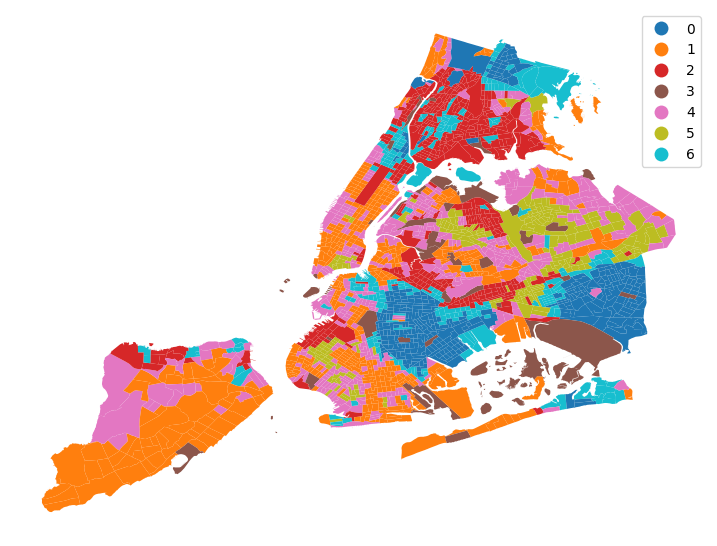

In [14]:
# Plot the different clusters with a choropleth (the labels are categorical values)
f, ax = plt.subplots(1, figsize=(9, 9))
nyc.plot(ax=ax, column='cluster_labels', categorical=True, legend=True)
ax.set_axis_off()
plt.show()

### Analyse the results: 

- *What do you find?*
- *What are the main characteristics of each cluster?*
- *How are clusters distributed geographically?*
- *Can you identify some groups concentrated on particular areas (e.g. China Town, Little Italy, East Harlem, etc)?*

**Note:** If the results doesn't make sense for you, maybe you can try again with a different number of clusters (`k`)

#### Answer the question here:

**This answer heavily depends on the number of clusters you've selected. Note also that the conclusions are purely based on the data at hand and no other information (and therefore, may be outdated)**

*What are the main characteristics of each cluster?*

Using the cluster centers (in this case, representing the mean of each feature grouped by cluster label) we can get the main characteristics for each cluster:

- Cluster 0 is where African people predominate. 
- Cluster 1 is where European people predominate.
- Cluster 2 is a mixture of Hispanic, European, and African, but Hispanic people predominate.
- Cluster 3 is a special case: there are almost no people living there **or** no data of demographics for those geometries.
- Cluster 4 is a mixture of European and Hispanic, but European people predominate.
- Cluster 5 is a mixture of Asian and European, but Asian predominate.
- Cluster 6 is a mixture of African, Hispanic, and European, (similar to cluster 2) but African people predominate in this case.

*How are clusters distributed geographically?*

We're going to use the 5 boroughs to structure the answer:
- In Manhattan, predominate cluster 1, 4, and 6. This implies that Manhattan is mainly composed by European. In some parts (cluster 4) there are also hispanic people living. In the north of Manhattan African people starts to predominate (cluster 6). Notably, in south Manhattan we can find a concentration of cluster 5 (Asian people) where China Town is. 
-  In the Bronx, clusters 2 and 6 predominate. This implies that the Bronx is mainly composed by Hispanic and African people. Notably one can see clearly where the predominance change (red and ligh blue color).
- In Queens, clusters 4 and 5 predominates and there is a strong presence of cluster 0 in the south-east. In the center of Queens, European and Asian predominates and one can also see where the composition change. In the south-east is where African people leave and there is a big geometry of cluster 3 (where no people live) that represents JFK airport.
- In Brooklyn, the biggest area is clusters 0 and 6 in the north-east and clusters 1 and 4 predominates in the south-west. This implies that the north-east is where Africans live and sout-west is where European people live.
- Finally, Staten Island is mainly composed of clusters 1 and 4 hence European people predominate in this borough.




## Task II: Regionalisation of Dar Es Salaam

For this task we will travel to Tanzania's Dar Es Salaam. We are using a dataset assembled to describe the built environment of the city centre. Let's load up the dataset before anything:

In [15]:
filepath = os.path.join('data', 'dar_es_salaam.geojson')
desalaam_df = gpd.read_file(filepath)

print(type(desalaam_df))
print(desalaam_df.shape)
desalaam_df.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
(1291, 7)


,index,id,street_length,street_linearity,building_density,building_coverage,geometry
0,897b4c16087ffff,897b4c8ce17ffff,0.011097,0.926700,138.0,15.789853,"POLYGON ((39.23750 -6.73264, 39.23752 -6.73071..."
1,897b4c16097ffff,897b4c8ec67ffff,0.009181,0.983710,33.0,3.722600,"POLYGON ((39.23914 -6.73559, 39.23916 -6.73366..."
2,897b4c160b3ffff,897b4c8eba3ffff,0.008357,0.962158,82.0,9.491595,"POLYGON ((39.23416 -6.73254, 39.23418 -6.73061..."
3,897b4c160b7ffff,897b4c8dd97ffff,0.021292,0.884537,122.0,7.245560,"POLYGON ((39.23082 -6.73244, 39.23084 -6.73050..."
4,897b4c16183ffff,897b4c8ce77ffff,0.008777,0.959906,113.0,11.806652,"POLYGON ((39.21745 -6.73202, 39.21747 -6.73009..."


Geographically, this is what we are looking at:

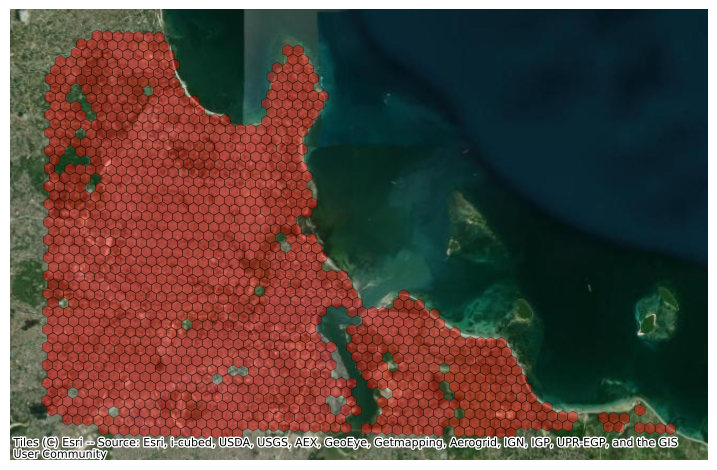

In [16]:
f, ax = plt.subplots(1, figsize=(9, 9))
desalaam_df.plot(ax=ax, facecolor="red", edgecolor="black", linewidth=0.5, alpha=0.4)
cx.add_basemap(ax=ax, crs=desalaam_df.crs, source=cx.providers.Esri.WorldImagery)
ax.set_axis_off()
plt.show()

Two main aspects of the built environment are considered: the street network and buildings. To capture those, the following variables are calculated at for the H3 hexagonal grid system, zoom level 8:

- `building_density`: number of buildings per hexagon
- `building_coverage`: proportion of the hexagon covered by buildings
- `street_length`: total length of streets within the hexagon
- `street_linearity`: a measure of how regular the street network is

**Note:** If you want to know more about the H3 grid system, check [this blog](https://www.uber.com/en-DE/blog/h3/) from Uber. There is also a python library called `h3` that let you work with this grid system. Check [this nice blog](https://towardsdatascience.com/uber-h3-for-data-analysis-with-python-1e54acdcc908) to learn how to use it (we'll not cover it in this course).




With these at hand, your task is the following:

### *Develop a regionalisation that partitions Dar Es Salaam based on its built environment*

For that, you can follow these suggestions:

- Create a spatial weights matrix to capture spatial relationships between hexagons
- Set up a regionalisation algorithm with a given number of clusters (e.g. seven)
- Generate a map with the output of the regionalisation algorithm and make sense of the regions found (ideally with a satellite image as basemap for context)
- Rinse and repeat with several combinations of variables and number of clusters
- Pick your best. *Why have you selected it? What does it show? What are the main groups of areas based on the built environment?*

```
These are only guidelines, feel free to follow your own approach to solve the task
```

**Hint 1:** Note that the features have different scales. In this case is always recommended to normalize the features first. You can do that easily using `MinMaxScaler` from `sklearn` (check the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) to understand how to use it).

**Hint 2:** Make sure that your spatial weight matrix doesn't have disconnected components. The regionalisation algorithm expects that there are no disconnected components. If you don't make sure of it you'll get unexpected results.


In [38]:
w = weights.KNN.from_dataframe(desalaam_df, k=5)

In [36]:
n_clusters = 4

#normalize features
scaler = MinMaxScaler()
X = desalaam_df[['street_length', 'street_linearity', 'building_density', 'building_coverage']]
X = scaler.fit_transform(X)

#cluster (define and fit)
sagg = cluster.AgglomerativeClustering(n_clusters=n_clusters, connectivity=w.sparse)
sagg.fit(X)

#add cluster label (result) to original df
desalaam_df['cluster_label'] = sagg.labels_

#print results
print(desalaam_df['cluster_label'].value_counts().sort_index())
desalaam_df.groupby('cluster_label')[['street_length', 'street_linearity', 'building_density', 'building_coverage']].mean()

cluster_label
0    832
1    129
2    260
3     70
Name: count, dtype: int64


/Users/iubeda/repos/SC-GSDA-WS2324/Assignments/env_ass5/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:304: UserWarning: the number of connected components of the connectivity matrix is 4 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


,street_length,street_linearity,building_density,building_coverage
cluster_label,,,,
0,0.013563,0.887209,120.973558,14.291010
1,0.035345,0.827246,696.612403,43.917660
2,0.019860,0.879965,447.338462,34.749220
3,0.023079,0.921954,370.242857,35.007878


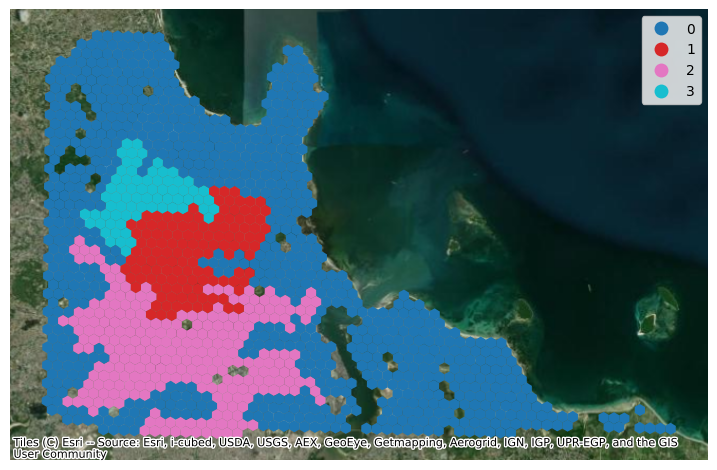

In [37]:
#visualization
f, ax = plt.subplots(1, figsize=(9, 9))
desalaam_df.plot(ax=ax, column='cluster_label', categorical=True, legend=True, linewidth=0.5)
cx.add_basemap(ax=ax, crs=desalaam_df.crs, source=cx.providers.Esri.WorldImagery)
ax.set_axis_off()
plt.show()

#### Answer the question here:

**This answer heavily depends on the number of clusters you've selected. Note also that the conclusions are purely based on the data at hand and no other information (and therefore, may be outdated)**

First of all, we've selected the KNN criteria to ensure that there are no disconnected components (with Queen, there are 4 disconnected components and 1 island, the geometries in the bottom-left of the figure)

*What are the main characteristics of each cluster?*

We're going to leave out the `street_linearity` in the analysis because is not clear how to interpret it. Furthermore, compared with the other features, there is no big difference between clusters. Using the mean of each feature grouped by cluster label we can get the main characteristics for each cluster:

- Cluster 0 has a low building coverage and building density. The street length are also low.
- Cluster 1 has a high building coverage and building density. The streets length are also high (totally opposed to cluster 0).
- Cluster 2 and 3 are relatively similar, this is between cluster 0 and 1 regarding building density and coverage and streets length.

*How are clusters distributed geographically?*

- Cluster 1 (red) is probably the city center. High building density and coverage. This is also geographically located in the center of the city.
- Cluster 2 and 3 are probably sububurs of the city center. They are relatively similar in building coverage but the south (cluster 2 in pink) has a higher building density but lower streets lenght than the north (cluster 3 in light blue).
- Cluster 0 (dark blue) is mostly presented on the coast and the south-east part of the city. Probably this part is not that urbanized yet compared with the other clusters.
